In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e15/sample_submission.csv
/kaggle/input/playground-series-s3e15/data.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import os, gc, pickle, datetime, lightgbm, math, catboost, xgboost, warnings
from scipy.cluster.hierarchy import dendrogram
from category_encoders.target_encoder import TargetEncoder
from colorama import Fore, Back, Style

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, EarlyStopping
from tensorflow.keras.layers import Dense, Input, Concatenate
from tensorflow.keras.utils import plot_model
import keras_tuner

from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin, clone
from sklearn.model_selection import RepeatedKFold, KFold
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, PolynomialFeatures, FunctionTransformer, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import Ridge, RidgeCV, LinearRegression, LassoCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor, VotingRegressor
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances
from sklearn.inspection import PartialDependenceDisplay
from sklearn.cluster import AgglomerativeClustering
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import sklearn.metrics
from matplotlib import pyplot
import itertools

colors = sns.color_palette("Set2")
np.set_printoptions(linewidth=150, edgeitems=5)
from collections import defaultdict
from typing import Any, Dict, Optional, Union
from matplotlib.axes import Axes

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
result_list = []
#Only one dataset!
train = pd.read_csv('/kaggle/input/playground-series-s3e15/data.csv', index_col='id')
#test = pd.read_csv('/kaggle/input/playground-series-s3e15/test.csv', index_col='id')
sample = pd.read_csv('/kaggle/input/playground-series-s3e15/sample_submission.csv')

print(f"Length of train:          {len(train)}")
#print(f"Length of test:           {len(test)}")
print()

print('Sample data from train:')
train.tail(10)

Length of train:          31644

Sample data from train:


,author,geometry,pressure [MPa],mass_flux [kg/m2-s],x_e_out [-],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2]
id,,,,,,,,,
31634,Richenderfer,plate,1.01,2000.0,NaN,15.0,120.0,10.0,6.2
31635,Thompson,tube,17.24,2984.0,-0.0417,1.9,1.9,152.0,3.9
31636,NaN,NaN,12.07,NaN,-0.0195,NaN,1.9,152.0,5.4
31637,Weatherhead,tube,13.79,688.0,NaN,NaN,11.1,457.0,2.3
31638,Thompson,tube,NaN,3648.0,-0.0487,4.7,4.7,318.0,9.0
31639,Thompson,NaN,NaN,1736.0,0.0886,NaN,7.8,591.0,2.3
31640,NaN,NaN,13.79,NaN,NaN,4.7,4.7,NaN,3.9
31641,Thompson,NaN,18.27,658.0,-0.1224,3.0,3.0,150.0,2.3
31642,Thompson,tube,6.89,3825.0,NaN,23.6,23.6,1972.0,3.7


In [4]:
sample

,id,x_e_out [-]
0,4,0.0
1,7,0.0
2,10,0.0
3,12,0.0
4,23,0.0
...,...,...
10410,31633,0.0
10411,31634,0.0
10412,31637,0.0
10413,31640,0.0


In [5]:
#choose data for training (where is not N/A in target)
train1 = train[pd.isna(train["x_e_out [-]"]) == False]

In [6]:
train1

,author,geometry,pressure [MPa],mass_flux [kg/m2-s],x_e_out [-],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2]
id,,,,,,,,,
0,Thompson,tube,7.00,3770.0,0.1754,NaN,10.8,432.0,3.6
1,Thompson,tube,NaN,6049.0,-0.0416,10.3,10.3,762.0,6.2
2,Thompson,NaN,13.79,2034.0,0.0335,7.7,7.7,457.0,2.5
3,Beus,annulus,13.79,3679.0,-0.0279,5.6,15.2,2134.0,3.0
5,NaN,NaN,17.24,3648.0,-0.0711,NaN,1.9,696.0,3.6
...,...,...,...,...,...,...,...,...,...
31636,NaN,NaN,12.07,NaN,-0.0195,NaN,1.9,152.0,5.4
31638,Thompson,tube,NaN,3648.0,-0.0487,4.7,4.7,318.0,9.0
31639,Thompson,NaN,NaN,1736.0,0.0886,NaN,7.8,591.0,2.3


In [7]:
x = train1.drop(['x_e_out [-]'], axis = 1)

In [8]:
x

,author,geometry,pressure [MPa],mass_flux [kg/m2-s],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2]
id,,,,,,,,
0,Thompson,tube,7.00,3770.0,NaN,10.8,432.0,3.6
1,Thompson,tube,NaN,6049.0,10.3,10.3,762.0,6.2
2,Thompson,NaN,13.79,2034.0,7.7,7.7,457.0,2.5
3,Beus,annulus,13.79,3679.0,5.6,15.2,2134.0,3.0
5,NaN,NaN,17.24,3648.0,NaN,1.9,696.0,3.6
...,...,...,...,...,...,...,...,...
31636,NaN,NaN,12.07,NaN,NaN,1.9,152.0,5.4
31638,Thompson,tube,NaN,3648.0,4.7,4.7,318.0,9.0
31639,Thompson,NaN,NaN,1736.0,NaN,7.8,591.0,2.3


**#Feature engineering -> creating features**

In [9]:
#1. clustering method for symptoms within the same category. Not used here, but used in other contest.

#def fe(df):
#    #symptom clusters:
#    cluster_0 = df.columns[df.columns.str.contains('pain')]
#    cluster_1 = df.columns[df.columns.str.contains('inflammation')]
#    cluster_2 = df.columns[df.columns.str.contains('bleed')]
#    cluster_3 = df.columns[df.columns.str.contains('skin')].tolist() + ['myalgia']
    
#    print(cluster_3)
    
#    df['cluster_0'] = df[cluster_0].sum(axis=1)
#    df['cluster_1'] = df[cluster_1].sum(axis=1)
#    df['cluster_2'] = df[cluster_2].sum(axis=1)
#    df['cluster_3'] = df[cluster_3].sum(axis=1)
    
#    return df

In [45]:
#combining every pair of features. For 0 or 1 data - can be used | & and ^ operations

def fe2(df):
    df = df.drop(['author'], axis = 1) #drop categorical values
    df = df.drop(['geometry'], axis = 1)
#    df = (df-df.min())/(df.max()-df.min()) # added later. Bad idea - terribly decreased score
    for col1, col2 in itertools.combinations(df, 2):
        df[f'{col1}_mult_{col2}'] = df[col1] * df[col2]
        df[f'{col1}_div_{col2}'] = df[col1] / df[col2]
        df[f'{col1}_sum_{col2}'] = df[col1] + df[col2] 
        df[f'{col1}_sub_{col2}'] = df[col1] - df[col2]
    return df

In [46]:
x2 = fe2(x)

In [47]:
x2

,pressure [MPa],mass_flux [kg/m2-s],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2],pressure [MPa]_mult_mass_flux [kg/m2-s],pressure [MPa]_div_mass_flux [kg/m2-s],pressure [MPa]_sum_mass_flux [kg/m2-s],pressure [MPa]_sub_mass_flux [kg/m2-s],...,D_h [mm]_sum_length [mm],D_h [mm]_sub_length [mm],D_h [mm]_mult_chf_exp [MW/m2],D_h [mm]_div_chf_exp [MW/m2],D_h [mm]_sum_chf_exp [MW/m2],D_h [mm]_sub_chf_exp [MW/m2],length [mm]_mult_chf_exp [MW/m2],length [mm]_div_chf_exp [MW/m2],length [mm]_sum_chf_exp [MW/m2],length [mm]_sub_chf_exp [MW/m2]
id,,,,,,,,,,,,,,,,,,,,,
0,0.335277,0.472727,NaN,0.082353,0.138907,0.151351,0.158495,0.709240,0.808004,-0.137450,...,0.221260,-0.056554,0.012464,0.544118,0.233704,-0.068998,0.021024,0.917780,0.290259,-0.012444
1,NaN,0.758495,0.254795,0.078151,0.247531,0.291892,NaN,NaN,NaN,NaN,...,0.325683,-0.169380,0.022812,0.267740,0.370043,-0.213741,0.072252,0.848024,0.539423,-0.044361
2,0.665209,0.255047,0.183562,0.056303,0.147136,0.091892,0.169660,2.608182,0.920256,0.410162,...,0.203439,-0.090834,0.005174,0.612704,0.148194,-0.035589,0.013521,1.601189,0.239028,0.055244
3,0.665209,0.461317,0.126027,0.119328,0.699144,0.118919,0.306872,1.441979,1.126526,0.203892,...,0.818472,-0.579816,0.014190,1.003438,0.238247,0.000409,0.083141,5.879167,0.818063,0.580225
5,0.832847,0.457429,NaN,0.007563,0.225806,0.151351,0.380969,1.820712,1.290277,0.375418,...,0.233369,-0.218243,0.001145,0.049970,0.158914,-0.143788,0.034176,1.491935,0.377158,0.074455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31636,0.581633,NaN,NaN,0.007563,0.046741,0.248649,NaN,NaN,NaN,NaN,...,0.054304,-0.039178,0.001881,0.030417,0.256212,-0.241086,0.011622,0.187981,0.295390,-0.201907
31638,NaN,0.457429,0.101370,0.031092,0.101382,0.443243,NaN,NaN,NaN,NaN,...,0.132475,-0.070290,0.013782,0.070148,0.474336,-0.412151,0.044937,0.228729,0.544626,-0.341861
31639,NaN,0.217680,NaN,0.057143,0.191244,0.081081,NaN,NaN,NaN,NaN,...,0.248387,-0.134101,0.004633,0.704762,0.138224,-0.023938,0.015506,2.358679,0.272325,0.110163


In [48]:
#Scaling
#Made affect on the result
x2 = (x2-x2.min())/(x2.max()-x2.min()) #for scaling after + and - adding features

In [49]:
x2

,pressure [MPa],mass_flux [kg/m2-s],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2],pressure [MPa]_mult_mass_flux [kg/m2-s],pressure [MPa]_div_mass_flux [kg/m2-s],pressure [MPa]_sum_mass_flux [kg/m2-s],pressure [MPa]_sub_mass_flux [kg/m2-s],...,D_h [mm]_sum_length [mm],D_h [mm]_sub_length [mm],D_h [mm]_mult_chf_exp [MW/m2],D_h [mm]_div_chf_exp [MW/m2],D_h [mm]_sum_chf_exp [MW/m2],D_h [mm]_sub_chf_exp [MW/m2],length [mm]_mult_chf_exp [MW/m2],length [mm]_div_chf_exp [MW/m2],length [mm]_sum_chf_exp [MW/m2],length [mm]_sub_chf_exp [MW/m2]
id,,,,,,,,,,,,,,,,,,,,,
0,0.335277,0.472727,NaN,0.082353,0.138907,0.151351,0.169985,0.0,0.418390,0.442820,...,0.160009,0.449036,0.018447,0.0,0.129928,0.478431,0.032554,0.0,0.169481,0.517558
1,NaN,0.758495,0.254795,0.078151,0.247531,0.291892,NaN,NaN,NaN,NaN,...,0.235524,0.390201,0.033761,0.0,0.212194,0.404050,0.111877,0.0,0.322138,0.500831
2,0.665209,0.255047,0.183562,0.056303,0.147136,0.091892,0.181960,0.0,0.476515,0.744808,...,0.147121,0.431160,0.007657,0.0,0.078332,0.495600,0.020936,0.0,0.138093,0.553032
3,0.665209,0.461317,0.126027,0.119328,0.699144,0.118919,0.329120,0.0,0.583323,0.631058,...,0.591894,0.176169,0.021002,0.0,0.132669,0.514099,0.128738,0.0,0.492854,0.828163
5,0.832847,0.457429,NaN,0.007563,0.225806,0.151351,0.408589,0.0,0.668114,0.725648,...,0.168766,0.364720,0.001694,0.0,0.084801,0.439998,0.052919,0.0,0.222722,0.563100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31636,0.581633,NaN,NaN,0.007563,0.046741,0.248649,NaN,NaN,NaN,NaN,...,0.039271,0.458097,0.002783,0.0,0.143509,0.389998,0.017996,0.0,0.172625,0.418264
31638,NaN,0.457429,0.101370,0.031092,0.101382,0.443243,NaN,NaN,NaN,NaN,...,0.095802,0.441873,0.020397,0.0,0.275123,0.302089,0.069582,0.0,0.325325,0.344917
31639,NaN,0.217680,NaN,0.057143,0.191244,0.081081,NaN,NaN,NaN,NaN,...,0.179626,0.408597,0.006857,0.0,0.072316,0.501587,0.024010,0.0,0.158494,0.581814


In [14]:
#return categorical values
x3 = x2.merge(x['author'],left_on='id', right_on='id')
x4 = x3.merge(x['geometry'],left_on='id', right_on='id')

x4.replace([np.inf, -np.inf], np.nan, inplace=True)
#x4.fillna(x4.mean(), inplace=True)
x4.fillna(x4.median(), inplace=True)#showed great affect

/tmp/ipykernel_122/1858321308.py:7: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  x4.fillna(x4.median(), inplace=True)#showed great affect


In [15]:
x4

,pressure [MPa],mass_flux [kg/m2-s],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2],pressure [MPa]_mult_mass_flux [kg/m2-s],pressure [MPa]_div_mass_flux [kg/m2-s],pressure [MPa]_sum_mass_flux [kg/m2-s],pressure [MPa]_sub_mass_flux [kg/m2-s],...,D_h [mm]_mult_chf_exp [MW/m2],D_h [mm]_div_chf_exp [MW/m2],D_h [mm]_sum_chf_exp [MW/m2],D_h [mm]_sub_chf_exp [MW/m2],length [mm]_mult_chf_exp [MW/m2],length [mm]_div_chf_exp [MW/m2],length [mm]_sum_chf_exp [MW/m2],length [mm]_sub_chf_exp [MW/m2],author,geometry
id,,,,,,,,,,,,,,,,,,,,,
0,0.335277,0.472727,0.186301,0.082353,0.138907,0.151351,0.171586,0.0,0.472781,0.527293,...,0.023627,0.036761,0.093059,0.186813,0.040358,0.043567,0.139196,0.143283,Thompson,tube
1,0.531098,0.758495,0.254795,0.078151,0.247531,0.291892,0.177531,0.0,0.343593,0.657948,...,0.039290,0.020069,0.109077,0.164103,0.123671,0.044626,0.248488,0.250458,Thompson,tube
2,0.665209,0.255047,0.183562,0.056303,0.147136,0.091892,0.182372,0.0,0.256324,0.745828,...,0.011318,0.037759,0.061022,0.172161,0.029509,0.066466,0.147049,0.151827,Thompson,NaN
3,0.665209,0.461317,0.126027,0.119328,0.699144,0.118919,0.329866,0.0,0.462240,0.539555,...,0.027840,0.062531,0.122044,0.223443,0.167773,0.259187,0.698278,0.700635,Beus,annulus
5,0.832847,0.457429,0.186301,0.007563,0.225806,0.151351,0.408918,0.0,0.458791,0.543875,...,0.003536,0.005935,0.025172,0.121612,0.065342,0.070307,0.225946,0.229704,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31636,0.581633,0.342320,0.186301,0.007563,0.046741,0.248649,0.177531,0.0,0.343593,0.657948,...,0.005681,0.003741,0.038902,0.108425,0.021052,0.010075,0.047779,0.051034,NaN,NaN
31638,0.531098,0.457429,0.101370,0.031092,0.101382,0.443243,0.177531,0.0,0.343593,0.657948,...,0.025771,0.005866,0.087719,0.102564,0.074712,0.012695,0.103509,0.104197,Thompson,tube
31639,0.531098,0.217680,0.186301,0.057143,0.191244,0.081081,0.177531,0.0,0.343593,0.657948,...,0.010497,0.041640,0.060259,0.174359,0.035208,0.093506,0.191016,0.195757,Thompson,NaN


In [16]:
y = pd.DataFrame(train1['x_e_out [-]'])

In [17]:
y

,x_e_out [-]
id,
0,0.1754
1,-0.0416
2,0.0335
3,-0.0279
5,-0.0711
...,...
31636,-0.0195
31638,-0.0487
31639,0.0886


In [18]:
#to avoid this: ValueError: feature_names must be string, and may not contain [, ] or <
import re

regex = re.compile(r"\[|\]|<", re.IGNORECASE)

y.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in y.columns.values]

x4.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in x4.columns.values]

In [19]:
#for enable_categorical=True
x4["author"] = x4["author"].astype("category")
x4["geometry"] = x4["geometry"].astype("category")

In [20]:
#XGB test
params = {'objective' : 'reg:squarederror',
          'eval_metric': 'rmse',      
          'reg_alpha': 1, # L1 =1 on default
          'reg_lambda': 0, # L2
          'learning_rate': 0.05, # 
          'max_depth': 6, #  
          'n_estimators': 300 # 
         }
clf = xgb.XGBRegressor(**params, tree_method="approx", enable_categorical=True)

In [21]:
clf.fit(x4,y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric='rmse', feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=300, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [22]:
#clf.fit(x4,y)

#param_grid = {
#    'n_estimators': range(100, 400, 50),
#    'max_depth': range (2, 10, 2), 
#    'learning_rate': [0.1, 0.01, 0.05]
#}

#grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='neg_mean_absolute_error', return_train_score=True)
#grid_search.fit(x4, y)
#best_model = grid_search.best_estimator_.fit(x4, y)

#result: learning_rate=0.05, max_depth=6, n_estimators=300

In [23]:
#sklearn.metrics.get_scorer_names()

In [24]:
clf.feature_importances_

array([0.01342632, 0.01127468, 0.03508197, 0.06204165, 0.03118128, 0.06661409, 0.00568482, 0.        , 0.00441571, 0.00762095, 0.00842559,
       0.00577513, 0.01315404, 0.00673986, 0.0090854 , 0.00868614, 0.02084572, 0.02511274, 0.00991117, 0.011294  , 0.00420714, 0.00946188,
       0.25478825, 0.00410764, 0.03720513, 0.01100611, 0.00573331, 0.00565619, 0.0075507 , 0.00578431, 0.00755795, 0.00474237, 0.00420115,
       0.0037559 , 0.00391324, 0.00427116, 0.00652679, 0.00524904, 0.00786869, 0.00344059, 0.00897459, 0.01038622, 0.00749167, 0.00106431,
       0.00878895, 0.01659105, 0.00655504, 0.00930711, 0.00597627, 0.00533046, 0.00436689, 0.00758266, 0.00578969, 0.0079378 , 0.00734983,
       0.0087825 , 0.00694751, 0.0081183 , 0.00501317, 0.01185016, 0.00581216, 0.00688381, 0.00459045, 0.03857639, 0.00987118, 0.01215231,
       0.01157755, 0.00293311], dtype=float32)

In [25]:
#Experimnet for choosing features
#importance = clf.feature_importances_
#def selectKImportance(model, X, k=5):
#     return X[:,model.feature_importances_.argsort()[::-1][:k]]

#newX = selectKImportance(clf,x4,2)
#newX

#for i,v in enumerate(importance):
#	print('Feature: %0d, Score: %.5f' % (i,v))

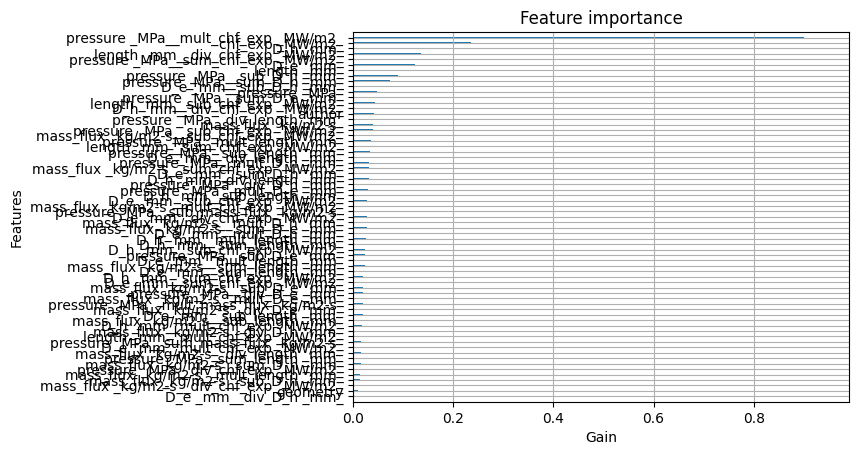

In [26]:
xgb.plot_importance(clf, 
                    importance_type="gain",
                    show_values=False,
                    xlabel="Gain");

In [27]:
#Select N most important features
#It made affect on the result witrh 20 features
#I tried 15, 30, 20, 25. 20 showed the best. 
x5 = x4.iloc[:,clf.feature_importances_.argsort()[::-1][:20]] # 20 is the best

In [28]:
x5

,pressure _MPa__mult_chf_exp _MW/m2_,chf_exp _MW/m2_,D_h _mm_,length _mm__div_chf_exp _MW/m2_,pressure _MPa__sum_chf_exp _MW/m2_,D_e _mm_,length _mm_,pressure _MPa__sub_D_h _mm_,pressure _MPa__sum_D_h _mm_,D_e _mm__sub_D_h _mm_,...,pressure _MPa__div_length _mm_,mass_flux _kg/m2-s_,pressure _MPa__sub_chf_exp _MW/m2_,mass_flux _kg/m2-s__sub_chf_exp _MW/m2_,pressure _MPa__mult_length _mm_,length _mm__sum_chf_exp _MW/m2_,pressure _MPa__sub_length _mm_,D_e _mm__div_length _mm_,pressure _MPa__mult_D_h _mm_,mass_flux _kg/m2-s__sum_chf_exp _MW/m2_
id,,,,,,,,,,,,,,,,,,,,,
0,0.083817,0.151351,0.082353,0.043567,0.277529,0.186301,0.138907,0.843873,0.121987,0.922518,...,0.008976,0.472727,0.594737,0.472728,0.074716,0.139196,0.857994,0.008044,0.034955,0.472529
1,0.107823,0.291892,0.078151,0.044626,0.417487,0.254795,0.247531,0.873746,0.142732,0.922518,...,0.008706,0.758495,0.702895,0.758027,0.155736,0.248488,0.799582,0.008044,0.046252,0.758336
2,0.114814,0.091892,0.056303,0.066466,0.447329,0.183562,0.147136,0.915758,0.148941,0.922518,...,0.016738,0.255047,0.802368,0.255295,0.155736,0.147049,0.852022,0.010140,0.049115,0.254929
3,0.137857,0.118919,0.119328,0.259187,0.462250,0.126027,0.699144,0.861244,0.203725,0.845036,...,0.003564,0.461317,0.789211,0.461399,0.727314,0.698278,0.302036,0.001190,0.096999,0.461055
5,0.207016,0.151351,0.007563,0.070307,0.583110,0.186301,0.225806,0.982992,0.131775,0.922518,...,0.013735,0.457429,0.864211,0.457438,0.296543,0.225946,0.774771,0.008044,0.015119,0.457247
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31636,0.217423,0.248649,0.007563,0.010075,0.482543,0.186301,0.046741,0.945414,0.094010,0.922518,...,0.044091,0.342320,0.680789,0.342568,0.045320,0.047779,0.951485,0.008044,0.010571,0.342089
31638,0.107823,0.443243,0.031092,0.012695,0.417487,0.101370,0.101382,0.873746,0.142732,0.922518,...,0.008706,0.457429,0.702895,0.456761,0.155736,0.103509,0.799582,0.008838,0.046252,0.457923
31639,0.107823,0.081081,0.057143,0.093506,0.417487,0.186301,0.191244,0.873746,0.142732,0.922518,...,0.008706,0.217680,0.702895,0.217972,0.155736,0.191016,0.799582,0.008044,0.046252,0.217575


In [29]:
#Training with N most important features
clf1 = xgb.XGBRegressor(**params, tree_method="approx", enable_categorical=True)
clf1.fit(x5,y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric='rmse', feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=300, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [30]:
x

,author,geometry,pressure [MPa],mass_flux [kg/m2-s],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2]
id,,,,,,,,
0,Thompson,tube,7.00,3770.0,NaN,10.8,432.0,3.6
1,Thompson,tube,NaN,6049.0,10.3,10.3,762.0,6.2
2,Thompson,NaN,13.79,2034.0,7.7,7.7,457.0,2.5
3,Beus,annulus,13.79,3679.0,5.6,15.2,2134.0,3.0
5,NaN,NaN,17.24,3648.0,NaN,1.9,696.0,3.6
...,...,...,...,...,...,...,...,...
31636,NaN,NaN,12.07,NaN,NaN,1.9,152.0,5.4
31638,Thompson,tube,NaN,3648.0,4.7,4.7,318.0,9.0
31639,Thompson,NaN,NaN,1736.0,NaN,7.8,591.0,2.3


**#For testing and submission**

In [31]:
X_test = train[pd.isna(train["x_e_out [-]"]) == True]
X_test2 = X_test.drop("x_e_out [-]", axis=1)

In [32]:
X_test2["author"] = X_test2["author"].astype("category")
X_test2["geometry"] = X_test2["geometry"].astype("category")

In [33]:
X_test2

,author,geometry,pressure [MPa],mass_flux [kg/m2-s],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2]
id,,,,,,,,
4,NaN,tube,13.79,686.0,11.1,11.1,457.0,2.8
7,Peskov,tube,18.00,750.0,10.0,10.0,1650.0,2.2
10,Thompson,tube,NaN,NaN,1.9,1.9,152.0,3.2
12,Thompson,NaN,6.89,7500.0,NaN,12.8,1930.0,4.8
23,Beus,annulus,15.51,1355.0,5.6,15.2,2134.0,2.1
...,...,...,...,...,...,...,...,...
31633,Thompson,tube,11.03,NaN,11.5,11.5,NaN,2.0
31634,Richenderfer,plate,1.01,2000.0,15.0,120.0,10.0,6.2
31637,Weatherhead,tube,13.79,688.0,NaN,11.1,457.0,2.3


In [34]:
X_testN = fe2(X_test2)

In [35]:
#Scaling
X_testN = (X_testN-X_testN.min())/(X_testN.max()-X_testN.min())

In [36]:
X_testN

,pressure [MPa],mass_flux [kg/m2-s],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2],pressure [MPa]_mult_mass_flux [kg/m2-s],pressure [MPa]_div_mass_flux [kg/m2-s],pressure [MPa]_sum_mass_flux [kg/m2-s],pressure [MPa]_sub_mass_flux [kg/m2-s],...,D_h [mm]_sum_length [mm],D_h [mm]_sub_length [mm],D_h [mm]_mult_chf_exp [MW/m2],D_h [mm]_div_chf_exp [MW/m2],D_h [mm]_sum_chf_exp [MW/m2],D_h [mm]_sub_chf_exp [MW/m2],length [mm]_mult_chf_exp [MW/m2],length [mm]_div_chf_exp [MW/m2],length [mm]_sum_chf_exp [MW/m2],length [mm]_sub_chf_exp [MW/m2]
id,,,,,,,,,,,,,,,,,,,,,
4,0.665209,0.086019,0.276712,0.084874,0.147136,0.108108,0.070343,0.0,0.087585,0.913464,...,0.149977,0.823803,0.016666,0.058733,0.084155,0.194872,0.046460,0.062747,0.147325,0.150420
7,0.869776,0.094044,0.246575,0.075630,0.539829,0.075676,0.100384,0.0,0.096123,0.905978,...,0.541046,0.445325,0.011513,0.067457,0.071266,0.191209,0.133015,0.289277,0.539446,0.541661
10,NaN,NaN,0.024658,0.007563,0.046741,0.129730,NaN,NaN,NaN,NaN,...,0.046886,0.917559,0.002480,0.008135,0.017437,0.124542,0.017249,0.018075,0.047157,0.050315
12,0.329932,0.940439,NaN,0.099160,0.631995,0.216216,0.384249,0.0,0.939677,0.059471,...,0.633834,0.357464,0.033893,0.039253,0.112206,0.192674,0.340492,0.154963,0.632379,0.632588
23,0.748785,0.169906,0.126027,0.119328,0.699144,0.070270,0.156273,0.0,0.171544,0.829919,...,0.701555,0.293566,0.017142,0.107878,0.109932,0.230037,0.164369,0.392040,0.698576,0.700341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31633,0.531098,NaN,0.287671,0.088235,NaN,0.064865,NaN,NaN,NaN,NaN,...,NaN,NaN,0.012081,0.085539,0.081122,0.203663,NaN,NaN,NaN,NaN
31634,0.044218,0.250784,0.383562,1.000000,0.000000,0.291892,0.015020,0.0,0.250468,0.747348,...,0.039045,1.000000,0.421208,0.289771,0.935557,0.967766,0.001620,0.000360,0.001447,0.002786
31637,0.665209,0.086270,NaN,0.084874,0.147136,0.081081,0.070548,0.0,0.087835,0.913213,...,0.149977,0.823803,0.013517,0.071670,0.080364,0.198535,0.038045,0.076444,0.147160,0.150583


In [37]:
X_test3 = X_testN.merge(X_test2['author'],left_on='id', right_on='id')
X_test4 = X_test3.merge(X_test2['geometry'],left_on='id', right_on='id')

X_test4.replace([np.inf, -np.inf], np.nan, inplace=True)
#X_test4.fillna(X_test4.mean(), inplace=True)
X_test4.fillna(X_test4.median(), inplace=True) #showed great affect

/tmp/ipykernel_122/1632238795.py:6: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  X_test4.fillna(X_test4.median(), inplace=True) #showed great affect


In [38]:
X_test4

,pressure [MPa],mass_flux [kg/m2-s],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2],pressure [MPa]_mult_mass_flux [kg/m2-s],pressure [MPa]_div_mass_flux [kg/m2-s],pressure [MPa]_sum_mass_flux [kg/m2-s],pressure [MPa]_sub_mass_flux [kg/m2-s],...,D_h [mm]_mult_chf_exp [MW/m2],D_h [mm]_div_chf_exp [MW/m2],D_h [mm]_sum_chf_exp [MW/m2],D_h [mm]_sub_chf_exp [MW/m2],length [mm]_mult_chf_exp [MW/m2],length [mm]_div_chf_exp [MW/m2],length [mm]_sum_chf_exp [MW/m2],length [mm]_sub_chf_exp [MW/m2],author,geometry
id,,,,,,,,,,,,,,,,,,,,,
4,0.665209,0.086019,0.276712,0.084874,0.147136,0.108108,0.070343,0.0,0.087585,0.913464,...,0.016666,0.058733,0.084155,0.194872,0.046460,0.062747,0.147325,0.150420,NaN,tube
7,0.869776,0.094044,0.246575,0.075630,0.539829,0.075676,0.100384,0.0,0.096123,0.905978,...,0.011513,0.067457,0.071266,0.191209,0.133015,0.289277,0.539446,0.541661,Peskov,tube
10,0.533042,0.343574,0.024658,0.007563,0.046741,0.129730,0.202579,0.0,0.343835,0.656734,...,0.002480,0.008135,0.017437,0.124542,0.017249,0.018075,0.047157,0.050315,Thompson,tube
12,0.329932,0.940439,0.205479,0.099160,0.631995,0.216216,0.384249,0.0,0.939677,0.059471,...,0.033893,0.039253,0.112206,0.192674,0.340492,0.154963,0.632379,0.632588,Thompson,NaN
23,0.748785,0.169906,0.126027,0.119328,0.699144,0.070270,0.156273,0.0,0.171544,0.829919,...,0.017142,0.107878,0.109932,0.230037,0.164369,0.392040,0.698576,0.700341,Beus,annulus
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31633,0.531098,0.343574,0.287671,0.088235,0.197498,0.064865,0.202579,0.0,0.343835,0.656734,...,0.012081,0.085539,0.081122,0.203663,0.076753,0.068150,0.197968,0.200374,Thompson,tube
31634,0.044218,0.250784,0.383562,1.000000,0.000000,0.291892,0.015020,0.0,0.250468,0.747348,...,0.421208,0.289771,0.935557,0.967766,0.001620,0.000360,0.001447,0.002786,Richenderfer,plate
31637,0.665209,0.086270,0.205479,0.084874,0.147136,0.081081,0.070548,0.0,0.087835,0.913213,...,0.013517,0.071670,0.080364,0.198535,0.038045,0.076444,0.147160,0.150583,Weatherhead,tube


In [39]:
regex = re.compile(r"\[|\]|<", re.IGNORECASE)

X_test4.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_test4.columns.values]

In [40]:
X_test4

,pressure _MPa_,mass_flux _kg/m2-s_,D_e _mm_,D_h _mm_,length _mm_,chf_exp _MW/m2_,pressure _MPa__mult_mass_flux _kg/m2-s_,pressure _MPa__div_mass_flux _kg/m2-s_,pressure _MPa__sum_mass_flux _kg/m2-s_,pressure _MPa__sub_mass_flux _kg/m2-s_,...,D_h _mm__mult_chf_exp _MW/m2_,D_h _mm__div_chf_exp _MW/m2_,D_h _mm__sum_chf_exp _MW/m2_,D_h _mm__sub_chf_exp _MW/m2_,length _mm__mult_chf_exp _MW/m2_,length _mm__div_chf_exp _MW/m2_,length _mm__sum_chf_exp _MW/m2_,length _mm__sub_chf_exp _MW/m2_,author,geometry
id,,,,,,,,,,,,,,,,,,,,,
4,0.665209,0.086019,0.276712,0.084874,0.147136,0.108108,0.070343,0.0,0.087585,0.913464,...,0.016666,0.058733,0.084155,0.194872,0.046460,0.062747,0.147325,0.150420,NaN,tube
7,0.869776,0.094044,0.246575,0.075630,0.539829,0.075676,0.100384,0.0,0.096123,0.905978,...,0.011513,0.067457,0.071266,0.191209,0.133015,0.289277,0.539446,0.541661,Peskov,tube
10,0.533042,0.343574,0.024658,0.007563,0.046741,0.129730,0.202579,0.0,0.343835,0.656734,...,0.002480,0.008135,0.017437,0.124542,0.017249,0.018075,0.047157,0.050315,Thompson,tube
12,0.329932,0.940439,0.205479,0.099160,0.631995,0.216216,0.384249,0.0,0.939677,0.059471,...,0.033893,0.039253,0.112206,0.192674,0.340492,0.154963,0.632379,0.632588,Thompson,NaN
23,0.748785,0.169906,0.126027,0.119328,0.699144,0.070270,0.156273,0.0,0.171544,0.829919,...,0.017142,0.107878,0.109932,0.230037,0.164369,0.392040,0.698576,0.700341,Beus,annulus
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31633,0.531098,0.343574,0.287671,0.088235,0.197498,0.064865,0.202579,0.0,0.343835,0.656734,...,0.012081,0.085539,0.081122,0.203663,0.076753,0.068150,0.197968,0.200374,Thompson,tube
31634,0.044218,0.250784,0.383562,1.000000,0.000000,0.291892,0.015020,0.0,0.250468,0.747348,...,0.421208,0.289771,0.935557,0.967766,0.001620,0.000360,0.001447,0.002786,Richenderfer,plate
31637,0.665209,0.086270,0.205479,0.084874,0.147136,0.081081,0.070548,0.0,0.087835,0.913213,...,0.013517,0.071670,0.080364,0.198535,0.038045,0.076444,0.147160,0.150583,Weatherhead,tube


In [41]:
#Use columns with 20 most important features
#1.Got this - feature_names mismatch:  (order?)
#. #dftrain_cols = x5.columns
#dftest_cols = X_test4.columns
#dfval1 = dftest_cols.difference(dftrain_cols)
#dfval1
#dftest = X_test4.drop(dfval1, axis=1)
#dftest

#2. X_test4 = X_test4.loc[:, x5.columns]

In [42]:
#Use the same features as in train
X_test5 = X_test4.iloc[:,clf.feature_importances_.argsort()[::-1][:20]] # 20 is the best

In [43]:
X_test5

,pressure _MPa__mult_chf_exp _MW/m2_,chf_exp _MW/m2_,D_h _mm_,length _mm__div_chf_exp _MW/m2_,pressure _MPa__sum_chf_exp _MW/m2_,D_e _mm_,length _mm_,pressure _MPa__sub_D_h _mm_,pressure _MPa__sum_D_h _mm_,D_e _mm__sub_D_h _mm_,...,pressure _MPa__div_length _mm_,mass_flux _kg/m2-s_,pressure _MPa__sub_chf_exp _MW/m2_,mass_flux _kg/m2-s__sub_chf_exp _MW/m2_,pressure _MPa__mult_length _mm_,length _mm__sum_chf_exp _MW/m2_,pressure _MPa__sub_length _mm_,D_e _mm__div_length _mm_,pressure _MPa__mult_D_h _mm_,mass_flux _kg/m2-s__sum_chf_exp _MW/m2_
id,,,,,,,,,,,,,,,,,,,,,
4,0.137140,0.108108,0.084874,0.062747,0.466107,0.276712,0.147136,0.894948,0.176353,0.863487,...,0.016738,0.086019,0.794474,0.087146,0.113153,0.147325,0.852019,0.015835,0.079676,0.085807
7,0.140663,0.075676,0.075630,0.289277,0.578358,0.246575,0.539829,0.933713,0.199407,0.863487,...,0.006035,0.094044,0.921053,0.095237,0.533330,0.539446,0.462138,0.003679,0.093703,0.093751
10,0.112555,0.129730,0.007563,0.018075,0.427239,0.024658,0.046741,0.878887,0.144848,0.863487,...,0.008616,0.343574,0.706053,0.344150,0.113153,0.047157,0.799578,0.007973,0.052034,0.343028
12,0.117387,0.216216,0.099160,0.154963,0.313744,0.205479,0.631995,0.832165,0.137806,0.863487,...,0.001957,0.940439,0.560263,0.940320,0.238780,0.632379,0.366664,0.008651,0.045884,0.939867
23,0.115600,0.070270,0.119328,0.392040,0.497823,0.126027,0.699144,0.877573,0.219496,0.784539,...,0.004012,0.169906,0.858158,0.171023,0.594357,0.698576,0.302587,0.001387,0.122742,0.169547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31633,0.078122,0.064865,0.088235,0.068150,0.355410,0.287671,0.197498,0.871879,0.158858,0.863487,...,0.008616,0.343574,0.742895,0.344150,0.113153,0.197968,0.799578,0.008651,0.066016,0.343028
31634,0.021793,0.291892,1.000000,0.000360,0.174440,0.383562,0.000000,0.006643,0.888881,0.000000,...,0.056087,0.250784,0.368684,0.251293,0.000163,0.001447,0.994428,1.000000,0.063076,0.250880
31637,0.112555,0.081081,0.084874,0.076444,0.450560,0.205479,0.147136,0.894948,0.176353,0.863487,...,0.016738,0.086270,0.807632,0.087459,0.113153,0.147160,0.852019,0.008651,0.079676,0.085995


In [44]:
submission = pd.DataFrame(sample['id'])
pred = clf1.predict(X_test5)
submission["x_e_out [-]"] = pred
submission.to_csv('submission.csv', index=None)
submission

,id,x_e_out [-]
0,4,-0.044653
1,7,-0.083734
2,10,-0.066853
3,12,-0.017953
4,23,0.064671
...,...,...
10410,31633,0.062101
10411,31634,-0.040110
10412,31637,0.008544
10413,31640,-0.061087
